In [5]:
import cirq
import qsimcirq
import numpy as np
import qiskit
import qiskit_ibm_runtime
from qiskit_aer import AerSimulator
import stimcirq
from qiskit.visualization import plot_histogram
from encoded.dj import dj, dj_steane, dj_tcc
from encoded.tcc import tcc_encoding
from encoded.LST import int_to_binary
import matplotlib.pyplot as plt

## Computer parameters

In [ ]:
# Computer and qubits to use.
# Option 1: Use saved noise characteristics.
#computer = AerSimulator()  # Noiseless simulator - use this for a sanity check to see all computed expectation
layout = {
    1 : [63, 64],
    7 : [61, 62, 63, 64, 65, 66, 67, 72, 73, 81, 82, 83, 84, 85]
    #7 : [117,122,123, 124, 125, 126, 127,136,137,143,144,145,146,147]
}

## Oracle definition

In [ ]:
total_qubits = 2
# Random case
# oracleType, oracleValue = np.random.randint(2), np.random.randint(2)
# if oracleType == 1:
#     oracleValue = np.random.randint(1, 2**(total_qubits-1))

# Fixed case
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
oracleType,oracleValue

(1, 1)

# Full connectivity

### Analog

In [4]:
n_shots = 600_000
noise = cirq.depolarize
noise_set = np.logspace(-3,-1,10)
infidelity_analog = []
for noise_ratio in noise_set:
    qreg = cirq.LineQubit.range(total_qubits)
    circuit = dj(qreg,oracleType,oracleValue)
    circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
    circuit = circuit.with_noise(noise(noise_ratio))
    simulator = stimcirq.StimSampler()
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")
    # if oracleType==1:
    infidelity_analog.append(1-counts[int(int_to_binary(total_qubits-1,oracleValue))]/n_shots)
    # else:
    #     infidelity_analog.append(1-counts[int("0"*(total_qubits-1))]/n_shots)

### Encoded

In [6]:
def codewords_tcc(n_encoding,distance):
    circuit = tcc_encoding(distance)
    qreg = cirq.LineQubit.range(n_encoding)
    circuit.append(cirq.measure(qreg, key="m"))
    simulator = stimcirq.StimSampler()
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")
    logical_0 = [format(key, '0'+str(n_encoding)+'b') for key in counts.keys()]
    logical_1 = [s.replace('1', '2').replace('0', '1').replace('2', '0') for s in logical_0]
    return logical_0, logical_1

In [8]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1


k = 2
distance = 3
n_encoding =7

logical_0_codeword,logical_1_codeword = codewords_tcc(n_encoding,distance)
qreg = cirq.LineQubit.range(n_encoding*k)
infidelity_encoded = []
for noise_ratio in noise_set:
    circuit= dj_tcc(qreg,distance,n_encoding,oracleType,oracleValue)
    circuit.append(cirq.measure(qreg[:n_encoding*(k-1)], key="m"))
    circuit = circuit.with_noise(noise(noise_ratio))
    simulator = stimcirq.StimSampler()
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")
    counts_logical_1 = 0
    for e in logical_1_codeword:
        counts_logical_1 += counts[int(e,2)]
    counts_logical_0 = 0
    for e in logical_0_codeword:
        counts_logical_0 += counts[int(e,2)]

    if oracleType==1 and oracleValue ==1:
        infidelity_encoded.append(1-counts_logical_1/(counts_logical_1+counts_logical_0))
    else:
        infidelity_encoded.append(1-counts_logical_0/(counts_logical_1+counts_logical_0))



In [9]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1


k = 2
distance = 5
n_encoding = 19

logical_0_codeword,logical_1_codeword = codewords_tcc(n_encoding,distance)
qreg = cirq.LineQubit.range(n_encoding*k)
infidelity_encoded_d5 = []
for noise_ratio in noise_set:
    circuit= dj_tcc(qreg,distance,n_encoding,oracleType,oracleValue)
    circuit.append(cirq.measure(qreg[:n_encoding*(k-1)], key="m"))
    circuit = circuit.with_noise(noise(noise_ratio))
    simulator = stimcirq.StimSampler()
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")
    counts_logical_1 = 0
    for e in logical_1_codeword:
        counts_logical_1 += counts[int(e,2)]
    counts_logical_0 = 0
    for e in logical_0_codeword:
        counts_logical_0 += counts[int(e,2)]

    if oracleType==1 and oracleValue ==1:
        infidelity_encoded_d5.append(1-counts_logical_1/(counts_logical_1+counts_logical_0))
    else:
        infidelity_encoded.append(1-counts_logical_0/(counts_logical_1+counts_logical_0))



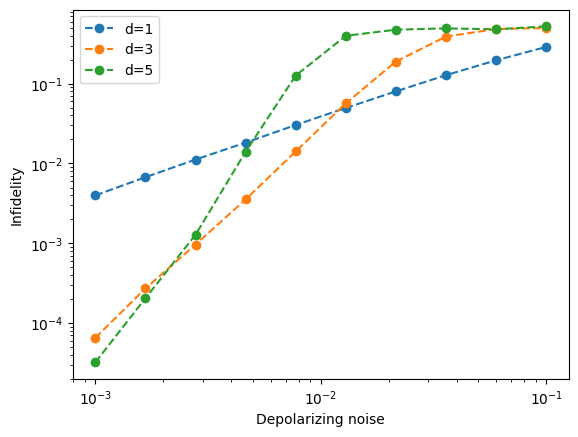

In [10]:
plt.figure()
plt.loglog(noise_set,infidelity_analog,"--o",label = "d=1")
plt.loglog(noise_set,infidelity_encoded,"--o",label = "d=3")
plt.loglog(noise_set,infidelity_encoded_d5,"--o",label = "d=5")


# plt.ylim(1e-4,5e-1)
plt.xlabel("Depolarizing noise")
plt.ylabel("Infidelity")
plt.legend()


# Transpiled

### Custom Fake provider

In [18]:
import json 
import pandas as pd
import os
from qiskit_ibm_runtime.fake_provider import fake_backend



def _load_json(filename: str) -> dict:
        with open(  # pylint: disable=unspecified-encoding
            os.path.join( filename)
        ) as f_json:
            the_json = json.load(f_json)
        return the_json


def update_computer_gate_noise(props_dict,new_dataset,gate_name_old,gate_name_new,scaling_factor):
    """
    Update and customize the noise model of the FakeKyiv computer backend.
    The noise can be updated using the noise calibration csv files that you can find 
    on the IBM quantum website.

    Warning: The scaling factor is not yet implemented

    Parameters
    ----------

    - props_dict [Dict]: the property dictionnary that describe the noise ratio of the 
                 custom Backend.
    - new_dataset [Dict]: the new dataset where you want to importe the noise
    - gate_name_old [string]: the gate that you want the noise value from the original dataset
    - gate_name_new [string]: the same gate name where you want to import the new noise
    - scaling factor [Float] : if you want to scale down or up the noise you can multiply the noise by
                      this factor  

    Returns
    -------
    - new_props_dict [Dict]: the updated props_dict with the new noise model

    """

    named_gates = [gate for gate in props_dict["gates"] if gate["gate"] == gate_name_old]
    #cleaning new dataset
    data_test  = list(new_dataset[gate_name_new].dropna())
    dictionary = {}

    # there are many ecr error value per lines of the dataset so one must be careful
    if gate_name_old == "ecr":
        for entry in data_test:
            pairs = entry.split(';')  
            for pair in pairs:
                key, value = pair.split(':')  
                key = list(map(int, key.split('_')))  
                dictionary[tuple(key)] = scaling_factor*float(value)

        # updating old dataset with new noise values
        for gate in named_gates:
            qubits = tuple(gate["qubits"])
            if qubits in dictionary:
                gate["parameters"][0]["value"] = dictionary[qubits]


    # single qubit case      
    else:
        for i,entry in enumerate(data_test):
            dictionary[i] = scaling_factor*(entry)
             
        for gate in named_gates:
            qubits = gate["qubits"][0]
            if qubits in dictionary:
                gate["parameters"][0]["value"] = dictionary[qubits]


    # Update props_dict elements with named_gates where the gate is gate_name_old
    for gate in props_dict["gates"]:
        if gate["gate"] == gate_name_old:
            matching_gate = next((named_gate for named_gate in named_gates if named_gate["qubits"] == gate["qubits"]), None)
            if matching_gate:
                gate.update(matching_gate)
    return props_dict




def update_computer_measurement_noise(old_dataset,new_dataset,scaling_factor):
    """
    Equivalent function for the measurement noise.
    Parameters
    ----------

    - old_datset:
    - old_datset:
    - scaling factor:

    Returns
    --------
    
    - Updated dataset
    """
    
    for i in range(len(old_dataset["qubits"])):
        old_dataset["qubits"][i][0]["value"] = new_dataset["T1 (us)"][i]
        old_dataset["qubits"][i][1]["value"] = new_dataset["T2 (us)"][i]
        old_dataset["qubits"][i][4]["value"] = scaling_factor*new_dataset["Readout assignment error "][i]
        old_dataset["qubits"][i][5]["value"] = scaling_factor*new_dataset["Prob meas0 prep1 "][i]
        old_dataset["qubits"][i][6]["value"] = scaling_factor*new_dataset["Prob meas1 prep0 "][i]
    return old_dataset


In [79]:
#importing datasets
old_dataset = _load_json("/Users/yanislefur/Documents/encoded/experiments/color/deutsch-jozsa/config/props_kyiv_backup.json")  
new_dataset = pd.read_csv("ibm_kyiv_calibrations_2025-02-26T16_02_56Z.csv")

old_keys = ["id","rz","sx","x","ecr"]
new_keys = ["ID error ","Z-axis rotation (rz) error ","√x (sx) error ","Pauli-X error ","ECR error "]

# updating noise
for i in range(len(old_keys)):
    update_computer_gate_noise(old_dataset,new_dataset,old_keys[i],new_keys[i],0.000001)
    update_computer_measurement_noise(old_dataset,new_dataset,0.000001)
with open("/Users/yanislefur/Documents/encoded/experiments/color/deutsch-jozsa/config/props_kyiv.json", "w") as f:
    json.dump(old_dataset, f)

print("New noise example:",old_dataset["gates"])
print("New noise example:",old_dataset["qubits"][0][4])

New noise example: [{'qubits': [0], 'gate': 'id', 'parameters': [{'date': '2024-02-28T02:04:14-05:00', 'name': 'gate_error', 'unit': '', 'value': 1.048485487606e-10}, {'date': '2024-02-28T08:25:01-05:00', 'name': 'gate_length', 'unit': 'ns', 'value': 49.77777777777777}], 'name': 'id0'}, {'qubits': [1], 'gate': 'id', 'parameters': [{'date': '2024-02-28T02:14:30-05:00', 'name': 'gate_error', 'unit': '', 'value': 9.82890885453e-11}, {'date': '2024-02-28T08:25:01-05:00', 'name': 'gate_length', 'unit': 'ns', 'value': 49.77777777777777}], 'name': 'id1'}, {'qubits': [2], 'gate': 'id', 'parameters': [{'date': '2024-02-28T02:04:14-05:00', 'name': 'gate_error', 'unit': '', 'value': 5.987368452499e-10}, {'date': '2024-02-28T08:25:01-05:00', 'name': 'gate_length', 'unit': 'ns', 'value': 49.77777777777777}], 'name': 'id2'}, {'qubits': [3], 'gate': 'id', 'parameters': [{'date': '2024-02-28T02:14:30-05:00', 'name': 'gate_error', 'unit': '', 'value': 1.06993619251e-10}, {'date': '2024-02-28T08:25:01-0

In [80]:
class Fake2025(fake_backend.FakeBackendV2):
    """A fake 127 qubit backend configuration updated 2025."""

    dirname = os.path.dirname("/Users/yanislefur/Documents/encoded/experiments/color/deutsch-jozsa/config")  # 
    conf_filename = "/Users/yanislefur/Documents/encoded/experiments/color/deutsch-jozsa/config/conf_kyiv.json" 
    props_filename = "/Users/yanislefur/Documents/encoded/experiments/color/deutsch-jozsa/config/props_kyiv.json" 
    defs_filename = "/Users/yanislefur/Documents/encoded/experiments/color/deutsch-jozsa/config/defs_kyiv.json" 
    backend_name = "fake_kyiv2025" 


In [81]:
computer = Fake2025()

## Analog version

In [89]:


n_shots = 500_000
qreg = cirq.LineQubit.range(total_qubits)
circuit = dj(qreg,oracleType,oracleValue)
circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[1],  
    routing_method="sabre",
    optimization_level=0,
)

job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()


In [90]:
compiled_raw.count_ops()

OrderedDict([('rz', 11), ('sx', 4), ('x', 2), ('ecr', 1), ('measure', 1)])

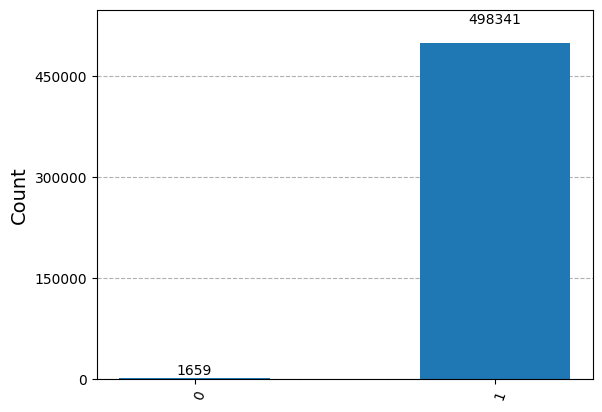

In [83]:
threshold = int(0.001 * n_shots) 
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold}
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

In [84]:
if oracleType==1:
    print("Total fidelity F = ",counts[int_to_binary(total_qubits-1,oracleValue)]/n_shots*100,"%")
else:
    print("Total fidelity F = ",counts["0"*(total_qubits-1)]/n_shots*100,"%")

Total fidelity F =  99.6682 %


## Encoding the Steane code (k = 2)

In [ ]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
logical_0_codeword,logical_1_codeword = codewords_tcc(7,3)


k = 2
qreg = cirq.LineQubit.range(7*k)
circuit= dj_tcc(qreg,3,7,oracleType,oracleValue)

circuit.append(cirq.measure(qreg[:7*(k-1)], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    routing_method="sabre", 
    optimization_level=3,
)
compiled_raw.count_ops()


OrderedDict([('rz', 324),
             ('sx', 181),
             ('ecr', 99),
             ('reset', 14),
             ('x', 14),
             ('measure', 7)])

In [87]:
compiled_raw.draw(fold = -1)

global phase: 3π/2
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
    ancilla_0 -> 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [69]:
job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

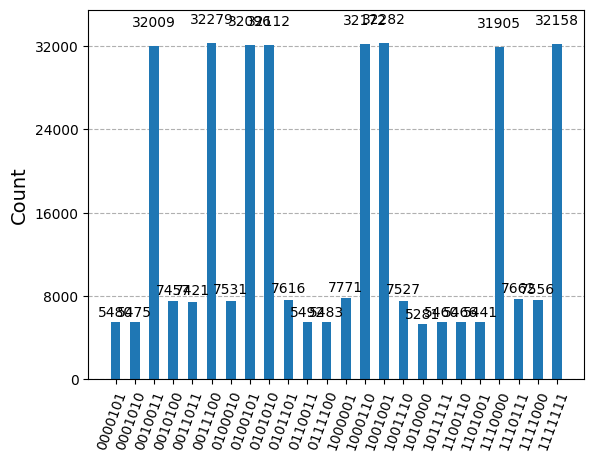

In [72]:
threshold = int(0.01 * n_shots)
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold} 
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

In [73]:
counts_logical_1 = 0
for e in logical_1_codeword:
    counts_logical_1 += counts[e]
counts_logical_0 = 0
for e in logical_0_codeword:
    counts_logical_0 += counts[e]

if oracleType==1 and oracleValue ==1:
    print("Total fidelity F = ",counts_logical_1/(counts_logical_1+counts_logical_0)*100,"%")
else:
    print("Total fidelity F = ",counts_logical_0/(counts_logical_1+counts_logical_0)*100,"%")

Total fidelity F =  80.85520164557751 %
